# CNN - Modelling (Multi + Origin + Embedded TL)

# 1. Load Images

In [1]:
import tensorflow as tf
%matplotlib inline

CLASS = "Mul"
PRE = "Ori"
TECH = "Embedded_TF"

print(tf.__version__)

2.4.2


In [2]:
! nvidia-smi

/bin/bash: switchml: line 1: syntax error: unexpected end of file
/bin/bash: error importing function definition for `switchml'
/bin/bash: _moduleraw: line 1: syntax error: unexpected end of file
/bin/bash: error importing function definition for `_moduleraw'
Sat Aug 21 04:42:59 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 450.142.00   Driver Version: 450.142.00   CUDA Version: 11.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            On   | 00000000:00:1E.0 Off |                    0 |
| N/A   44C    P8    10W /  70W |      0MiB / 15109MiB |      0%    

Due to insufficient memory, we have no choice but import all images into a 150 $\times$ 150 smaller arrays.

In [3]:
SRC_MULTI = "/home/ubuntu/crack/Origin-Multi/"

from crack_utils import load_multi_dataset
from tensorflow.keras.utils import to_categorical

x_train, x_test, y_train, y_test = load_multi_dataset(SRC_MULTI, (150, 150), color_mode="rgb")

# convert integers to dummy variables (i.e. one hot encoded)
y_train = to_categorical(y_train)
y_test = to_categorical(y_test)

# 2. Pretrain Model as Embedded Feature Extractor 

Only use the deep layers (roughly the first 1/3 of the whole network) from pre-trained model to learn elementary features. Then we build our model (VGG blocks) upon that to learn deeper features. 

Since we dont have a large number of samples, the number VGG blocks to add is arbitrarily selected as 2 and each block has two convolutional layer, one max pooling layer and one dropout layer.

We've discarded 2 pretrained model used in standalone TL:

* **VGG19**: we've found it not trainable after adding customized VGG blocks.

* **NASNetLarge**: the network structure is not linear, thus hard to be embedded customized VGG blocks.

## 2.1 ResNet152V2

In [4]:
from tensorflow.keras.applications import ResNet152V2
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dropout
from crack_utils import vgg_block, classification_block, multiple_compile

def ResNet152V2_Embedded(dropout=True):
    # create pre-trained model instance
    model = ResNet152V2(include_top=False, input_shape=(150, 150, 3))
    # mark loaded layers as not trainable
    for layer in model.layers:
        layer.trainable = False
    # arbitrarily select output layer from pre-trained model
    out = model.get_layer('conv3_block1_preact_relu').output
     # add vgg module
    layer = vgg_block(out, 64, 2)
    if dropout:
        layer = Dropout(0.3)(layer)
    # add vgg module
    layer = vgg_block(layer, 128, 2)
    if dropout:
        layer = Dropout(0.4)(layer)
    # add classification block
    layer = classification_block(layer, 32, classes=5)
    # create model
    model = Model(inputs=model.inputs, outputs=layer)
    return model

# create model instance
model = ResNet152V2_Embedded()
multiple_compile(model, 0.0005, 0.9)
model.layers[-3].output_shape

Extension horovod.torch has not been built: /home/ubuntu/anaconda3/envs/tensorflow2_latest_p37/lib/python3.7/site-packages/horovod/torch/mpi_lib/_mpi_lib.cpython-37m-x86_64-linux-gnu.so not found
If this is not expected, reinstall Horovod with HOROVOD_WITH_PYTORCH=1 to debug the build error.
Warning! MPI libs are missing, but python applications are still avaiable.
[2021-08-21 04:43:10.915 ip-172-31-5-51:16209 INFO utils.py:27] RULE_JOB_STOP_SIGNAL_FILENAME: None
[2021-08-21 04:43:10.938 ip-172-31-5-51:16209 INFO profiler_config_parser.py:102] Unable to find config at /opt/ml/input/config/profilerconfig.json. Profiler is disabled.


(None, 2048)

In [5]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.resnet_v2 import preprocess_input as pre_resnet_v2

datagen_train = ImageDataGenerator(horizontal_flip=True,
                                    vertical_flip=True,
                                    preprocessing_function=pre_resnet_v2)

datagen_test = ImageDataGenerator(preprocessing_function=pre_resnet_v2)

train_it = datagen_train.flow(x_train, y_train, batch_size=64, seed=100)
test_it = datagen_test.flow(x_test, y_test, batch_size=64, shuffle=False)

In [6]:
%%time

histories = dict()

model_name = "{}_{}_TL2_ResNet152V2".format(CLASS, PRE)
histories[model_name] = model.fit(x=train_it, steps_per_epoch=len(train_it),
              validation_data=test_it, validation_steps=len(test_it), epochs=30, verbose=0).history

CPU times: user 57.5 s, sys: 10 s, total: 1min 7s
Wall time: 1min 4s


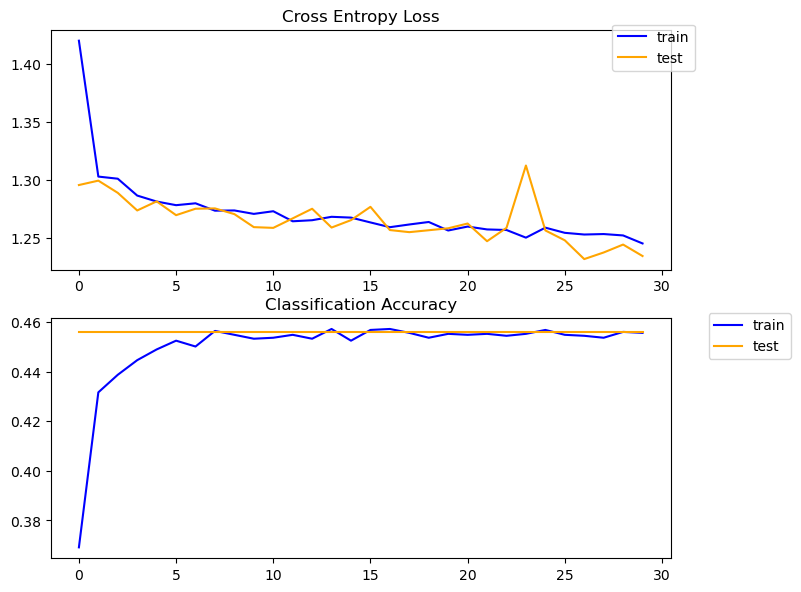

In [7]:
from crack_utils import summarize_diagnostics_multi
                                           
summarize_diagnostics_multi(histories[model_name], "model_plot/{}.png".format(model_name))

In [8]:
from crack_utils import show_result_multi

results = dict()

results[model_name] = show_result_multi(model, test_it, y_test)
del model

Test loss: 1.23
Test accuracy: 0.46
Test f1 micro: 0.46
Test f1 macro: 0.13
Test f1 weighted: 0.29


## 2.2 DenseNet201

In [9]:
from tensorflow.keras.applications import DenseNet201

def DenseNet201_Embedded(dropout=True):
    # create pre-trained model instance
    model = DenseNet201(include_top=False, input_shape=(150, 150, 3))
    # mark loaded layers as not trainable
    for layer in model.layers:
        layer.trainable = False
    # arbitrarily select output layer from pre-trained model
    out = model.get_layer('pool2_pool').output
    # add vgg module
    layer = vgg_block(out, 64, 2)
    if dropout:
        layer = Dropout(0.3)(layer)
    layer = vgg_block(layer, 128, 2)
    if dropout:
        layer = Dropout(0.4)(layer)
    # add classification block
    layer = classification_block(layer, 32, classes=5)
    # create model
    model = Model(inputs=model.inputs, outputs=layer)
    return model

# create model instance
model = DenseNet201_Embedded()
multiple_compile(model, 0.0005, 0.9)
model.layers[-3].output_shape

(None, 2048)

In [10]:
from tensorflow.keras.applications.densenet import preprocess_input as pre_densenet

datagen_train = ImageDataGenerator(horizontal_flip=True,
                                    vertical_flip=True,
                                    preprocessing_function=pre_densenet)

datagen_test = ImageDataGenerator(preprocessing_function=pre_densenet)

train_it = datagen_train.flow(x_train, y_train, batch_size=64, seed=100)
test_it = datagen_test.flow(x_test, y_test, batch_size=64, shuffle=False)

In [11]:
%%time

model_name = "{}_{}_TL2_DenseNet201".format(CLASS, PRE)
histories[model_name] = model.fit(x=train_it, steps_per_epoch=len(train_it),
              validation_data=test_it, validation_steps=len(test_it), epochs=30, verbose=0).history

CPU times: user 1min 11s, sys: 9.91 s, total: 1min 21s
Wall time: 1min 11s


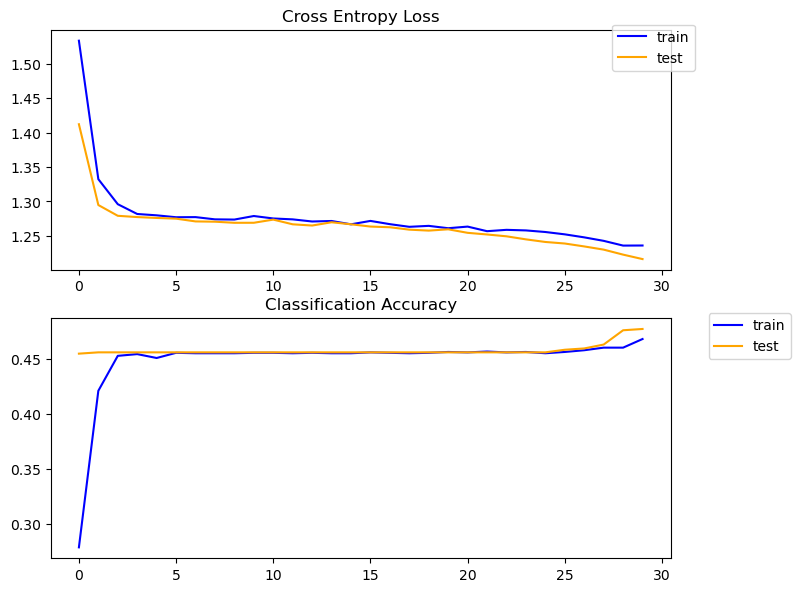

In [12]:
summarize_diagnostics_multi(histories[model_name], "model_plot/{}.png".format(model_name))

In [13]:
results[model_name] = show_result_multi(model, x_test, y_test, y_test)
del model

Test loss: 3.51
Test accuracy: 0.47
Test f1 micro: 0.47
Test f1 macro: 0.17
Test f1 weighted: 0.33


## 2.3 InceptionV3

In [14]:
from tensorflow.keras.applications import InceptionV3

def InceptionV3_Embedded(dropout=True):
    # create pre-trained model instance
    model = InceptionV3(include_top=False, input_shape=(150, 150, 3))
    # mark loaded layers as not trainable
    for layer in model.layers:
        layer.trainable = False
    # arbitrarily select output layer from pre-trained model
    out = model.get_layer("mixed2").output 
    # add vgg module
    layer = vgg_block(out, 64, 2)
    if Dropout:
        layer = Dropout(0.3)(layer)
    layer = vgg_block(layer, 128, 2)
    if Dropout:
        layer = Dropout(0.4)(layer)
    # add classification block
    layer = classification_block(layer, 32, classes=5)
    # create model
    model = Model(inputs=model.inputs, outputs=layer)
    return model

# create model instance
model = InceptionV3_Embedded()
multiple_compile(model, 0.0005, 0.9)
model.layers[-3].output_shape

(None, 2048)

In [15]:
from tensorflow.keras.applications.inception_v3 import preprocess_input as pre_inception_v3

datagen_train = ImageDataGenerator(horizontal_flip=True,
                                    vertical_flip=True,
                                    preprocessing_function=pre_inception_v3)

datagen_test = ImageDataGenerator(preprocessing_function=pre_inception_v3)

train_it = datagen_train.flow(x_train, y_train, batch_size=64, seed=100)
test_it = datagen_test.flow(x_test, y_test, batch_size=64, shuffle=False)

In [16]:
%%time

model_name = "{}_{}_TL2_InceptionV3".format(CLASS, PRE)
histories[model_name] = model.fit(x=train_it, steps_per_epoch=len(train_it),
              validation_data=test_it, validation_steps=len(test_it), epochs=30, verbose=0).history

CPU times: user 55.6 s, sys: 16.6 s, total: 1min 12s
Wall time: 52.9 s


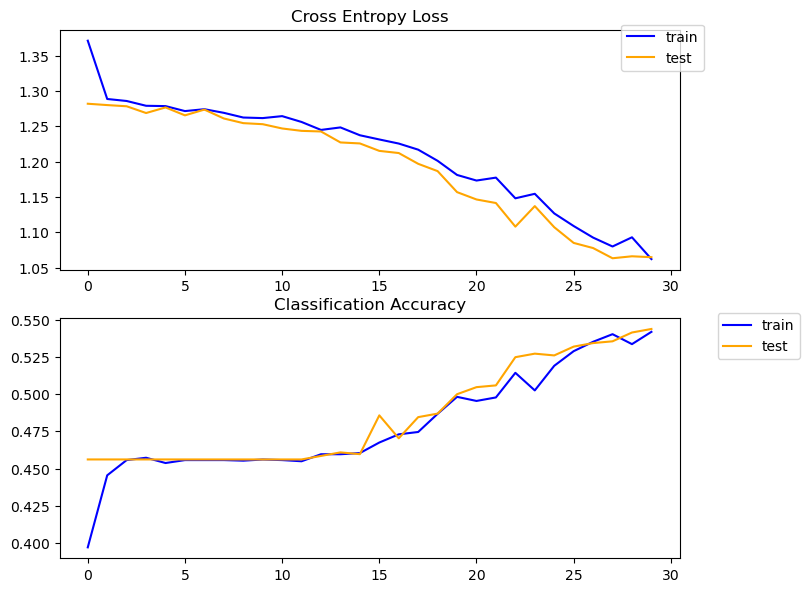

In [17]:
summarize_diagnostics_multi(histories[model_name], "model_plot/{}.png".format(model_name))

In [18]:
results[model_name] = show_result_multi(model, x_test, y_test, y_test)
del model

Test loss: 1007.19
Test accuracy: 0.19
Test f1 micro: 0.19
Test f1 macro: 0.06
Test f1 weighted: 0.06


## 2.4 InceptionResNetV2

In [19]:
from tensorflow.keras.applications import InceptionResNetV2

def InceptionResNetV2_Embedded(dropout=True):
    # create pre-trained model instance
    model = InceptionResNetV2(include_top=False, input_shape=(150, 150, 3))
    # mark loaded layers as not trainable
    for layer in model.layers:
        layer.trainable = False
    # arbitrarily select output layer from pre-trained model
    out = model.get_layer('block35_6').output
    # add vgg module
    layer = vgg_block(out, 64, 2)
    if Dropout:
        layer = Dropout(0.3)(layer)
    layer = vgg_block(layer, 128, 2)
    if Dropout:
        layer = Dropout(0.4)(layer)
    # add classification block
    layer = classification_block(layer, 32, classes=5)
    # create model
    model = Model(inputs=model.inputs, outputs=layer)
    return model

# create model instance
model = InceptionResNetV2_Embedded()
multiple_compile(model, 0.0005, 0.9)
model.layers[-3].output_shape

(None, 2048)

In [20]:
from tensorflow.keras.applications.inception_resnet_v2 import preprocess_input as pre_inception_resnet_v2

datagen_train = ImageDataGenerator(horizontal_flip=True,
                                    vertical_flip=True,
                                    preprocessing_function=pre_inception_resnet_v2)

datagen_test = ImageDataGenerator(preprocessing_function=pre_inception_resnet_v2)

train_it = datagen_train.flow(x_train, y_train, batch_size=64, seed=100)
test_it = datagen_test.flow(x_test, y_test, batch_size=64, shuffle=False)

In [21]:
%%time

model_name = "{}_{}_TL2_InceptionResNetV2".format(CLASS, PRE)
histories[model_name] = model.fit(x=train_it, steps_per_epoch=len(train_it),
              validation_data=test_it, validation_steps=len(test_it), epochs=30, verbose=0).history

CPU times: user 1min 5s, sys: 15.8 s, total: 1min 21s
Wall time: 1min 4s


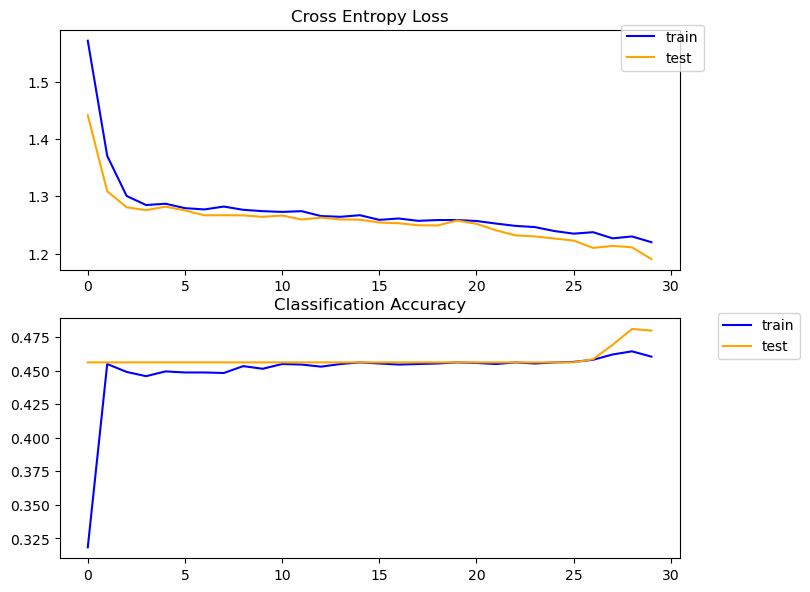

In [22]:
summarize_diagnostics_multi(histories[model_name], "model_plot/{}.png".format(model_name))

In [23]:
results[model_name] = show_result_multi(model, x_test, y_test, y_test)
del model

Test loss: 12.18
Test accuracy: 0.46
Test f1 micro: 0.46
Test f1 macro: 0.13
Test f1 weighted: 0.29


## 2.5 Xception

In [24]:
from tensorflow.keras.applications import Xception

def Xception_Embedded(dropout=True):
    # create pre-trained model instance
    model = Xception(include_top=False, input_shape=(150, 150, 3))
    # mark loaded layers as not trainable
    for layer in model.layers:
        layer.trainable = False
    # arbitrarily select output layer from pre-trained model
    out = model.layers[25].output
    # add vgg module
    layer = vgg_block(out, 64, 2)
    if Dropout:
        layer = Dropout(0.3)(layer)
    layer = vgg_block(layer, 128, 2)
    if Dropout:
        layer = Dropout(0.4)(layer)
    # add classification block
    layer = classification_block(layer, 32, classes=5)
    # create model
    model = Model(inputs=model.inputs, outputs=layer)
    return model

# create model instance
model = Xception_Embedded()
multiple_compile(model, 0.0005, 0.9)
model.layers[-3].output_shape

(None, 2048)

In [25]:
from tensorflow.keras.applications.xception import preprocess_input as pre_xception

datagen_train = ImageDataGenerator(horizontal_flip=True,
                                    vertical_flip=True,
                                    preprocessing_function=pre_xception)

datagen_test = ImageDataGenerator(preprocessing_function=pre_xception)

train_it = datagen_train.flow(x_train, y_train, batch_size=64, seed=100)
test_it = datagen_test.flow(x_test, y_test, batch_size=64, shuffle=False)

In [26]:
%%time

model_name = "{}_{}_TL2_Xception".format(CLASS, PRE)
histories[model_name] = model.fit(x=train_it, steps_per_epoch=len(train_it),
              validation_data=test_it, validation_steps=len(test_it), epochs=30, verbose=0).history

CPU times: user 55.9 s, sys: 6.67 s, total: 1min 2s
Wall time: 1min 9s


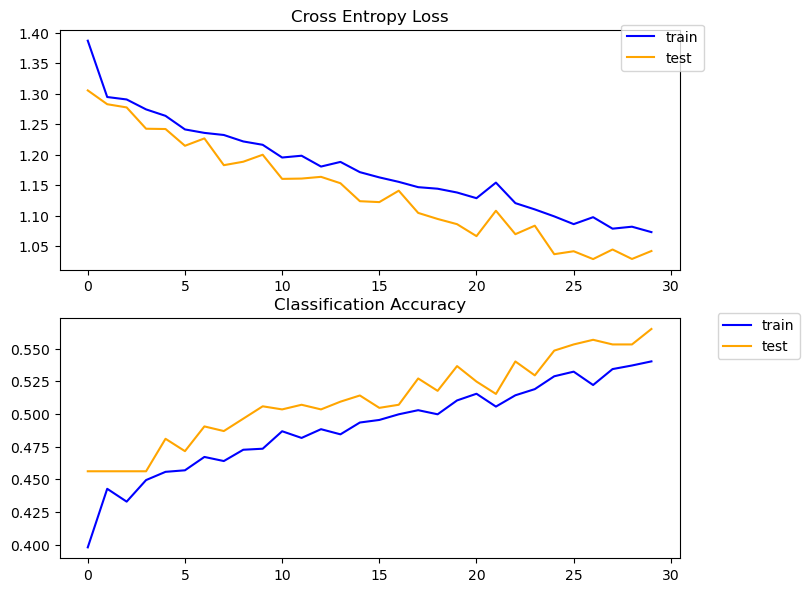

In [27]:
summarize_diagnostics_multi(histories[model_name], "model_plot/{}.png".format(model_name))

In [28]:
results[model_name] = show_result_multi(model, x_test, y_test, y_test)
del model

Test loss: 285.33
Test accuracy: 0.46
Test f1 micro: 0.46
Test f1 macro: 0.13
Test f1 weighted: 0.29


# 3. Summary

Final result:

In [29]:
from crack_utils import get_final_result

get_final_result(results).round(2)

,Mul_Ori_TL2_ResNet152V2,Mul_Ori_TL2_DenseNet201,Mul_Ori_TL2_InceptionV3,Mul_Ori_TL2_InceptionResNetV2,Mul_Ori_TL2_Xception
Loss,1.23,3.51,1007.19,12.18,285.33
Accuracy,0.46,0.47,0.19,0.46,0.46
F1 Micro,0.46,0.47,0.19,0.46,0.46
F1 Macro,0.13,0.17,0.06,0.13,0.13
F1 Weighted,0.29,0.33,0.06,0.29,0.29


Compare each model:

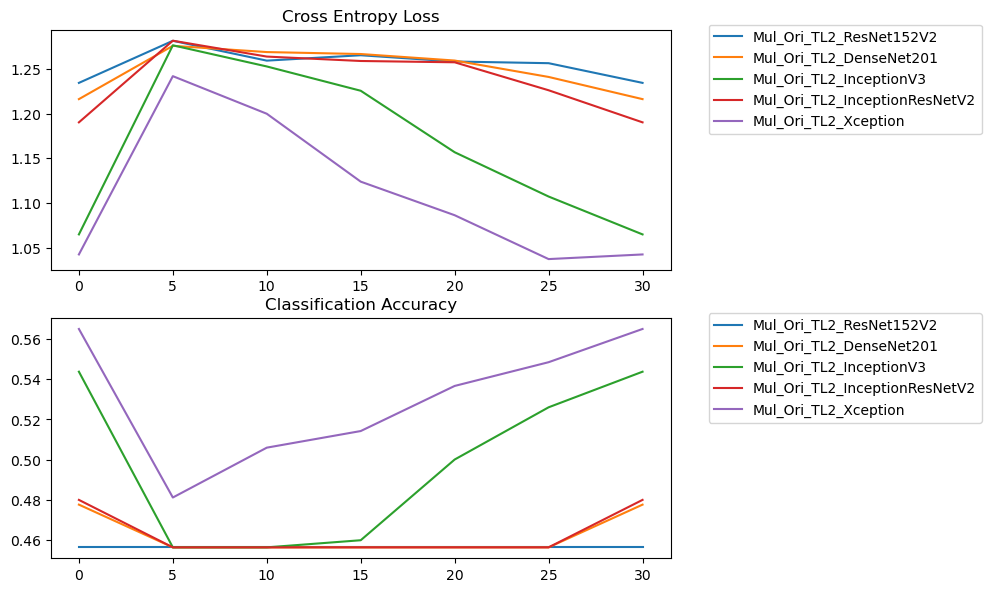

In [30]:
from crack_utils import compare_all_result_multi

compare_all_result_multi(histories, filename="model_plot/Compare_{}_{}_{}.png".format(CLASS, PRE, TECH), end=30, step=5)

Save epochs history:

In [32]:
from crack_utils import save_history

save_history(histories, folder="epochs_history")